# Neural Network Classifier

In this assignment, your task is to train a type of Neural network classifier on the synthetic dataset that was also used in previous assignements. Please read the assignment entirely before you start coding. Most of the code that implements the neural network functionalities are provided to you. What you are expected to do is fill in certain missing parts that are required and then train two different networks and visualize the estimated posterior.

- <a href='#non-linear-activation-functions'>Question 1</a> (10%) Fill in the code to 
implement the `sigmoid` and `relu` functions and their derivatives. Then, plot all four 
functions to verify that your implementation is correct. See the provided example first.
- <a href='#the-neural-network'>Question 2</a> (80%) Fill in the code inside the 
`NeuralNetwork` class where necessary.
    - <a href='#feedforward1'>a.</a> First, complete the code in the `feedforward` method of the `NeuralNetwork` class. Assuming that the input of the $l$-th layer of the network is $a^{l-1}$ ($a^{l-1}$ can be the non-linear output or activation of a previous layer or initially the input feature vector) then the linear-output of the layer is: $$z^{l}=W a^{l-1} + b$$ Then the non-linear output or "activation" is $a^{l} = f(z^{l})$ where $f(\cdot)$ is the non-linear activation function of the layer, applied element-wise on $z^{l}$. In our case, $f(\cdot)$ is either a `sigmoid` or `relu` function.
    - <a href='#feedforward2'>b.</a> In the `feedforward` method of the `NeuralNetwork` class, write the code that implements the softmax function (see pages 67, 73 of the course slides). If $z^{L}$ is the linear-output of the output layer of the network then applying the softmax function on each of its elements $z^{L}_k$ is described by: 
    
    $$ softmax(z_k) = \frac{\exp(z^{L}_k)}{\sum_{k}\exp(z^{L}_k)}, k=0,...,C-1$$
Note: $z^{L}$ will be a 2-dimensional vector as our synthetic dataset has $C=2$ classes. Consequently $softmax(z^{L}_{0}) = P_{estimated}(y=0 \mid x)$ and $softmax(z^{L}_{1}) = P_{estimated}(y=1 \mid x)$. 
    - <a href='#loss_function'>c.</a> Fill in the `loss_function` method of the `
    NeuralNetwork` class so that it computes the value of the loss used to train the network (see page 68 of the coures slides, where it is refered to as "optimization criterion"): 
$$L(W) = - \sum_{i=1}^{N} \sum_{c=0}^{1} y_{c}^{i} \log (g_{c}(x^{i}; W))$$
where $i$ indexes training examples, $c$ indexes the two classes {0,1} of our synthetic 
data, $W$ is the set of weights of the network and $g_{c}$ is the posterior of class $c$ as 
computed by the network. As implied in pages 68 and 70 of the course slides, for $y^{i}$ 
being the true class label of example $x^{i}$, $y_{c}^{i}$ is the one-hot label encoding of
$y^{i}$, meaning that $y_{c}^{i}=1$ if $y^{i}=c$ and $y_{c}^{i}=0$ if $y^{i} \neq c$. Use 
the gradient checking code (found <a href='#checking'>here</a>) to ensure all your additions 
to the `NeuralNetwork` class are working correctly.
    - <a href='#backprop'>d.</a> Go through and try to understand the `backprop` method of 
the `Neural Network` class which is provided. Briefly explain what is done by the for 
loop at the end of the `backprop` method. Add your explanation in a markdown cell which <a href='#backprop'>here</a>. 
- <a href='#Train-networks'>Question 3</a> (10%) Use the `NeuralNetwork` class to define and train two different neural networks.
    - <a href='#Define-Network'>a.</a> Train a network with a sigmoid non-linear activation 
    function. Then plot the accuracy and error curves. Finally, visualize the estimated 
    posterior. The code needed is provided. 
    - <a href='#Train2'>b.</a> By using the previous question's code as an example, train a 
 network with relu non-linear activation functions. Then with the provided code, plot the accuracy and error 
 curves and visualize the estimated posterior. Briefly  compare the performance of the two 
 networks in a markdown cell which must be added at the end of this notebook <a href='#Compare'>here</a>.

# Code

## Imports

In [16]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pickle
from numpy.random import RandomState
from construct_data import construct_data
from gradientChecking import checkNNGradients, compute_numerical_gradient 

## Data Generation - Visualization

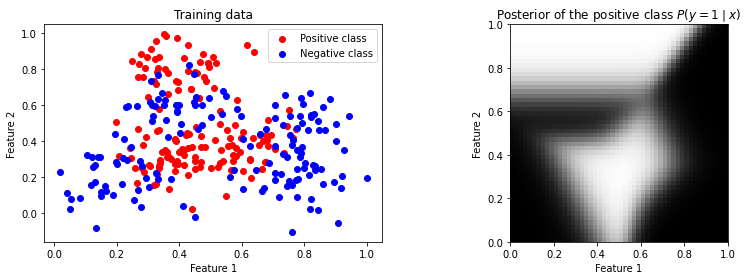

In [17]:
prng = RandomState(1)

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

features, labels, posterior = construct_data(300, 'train', 'nonlinear', plusminus=False)

# Extract features for both classes
features_pos = features[labels == 1]
features_neg = features[labels != 1]

# Display data
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(features_pos[:, 0], features_pos[:, 1], c="red", label="Positive class")
ax.scatter(features_neg[:, 0], features_neg[:, 1], c="blue", label="Negative class")

ax.set_title("Training data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Posterior of the positive class $P(y=1 \mid x)$")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

plt.show()

# Our dataset arrays are modified to have a more convenient format for this assignement 
# instead of two arrays features (300,2) and labels (300,)
# we now have a list of 300 elements called data 
# each element of data is a tuple (x,y) 
# where x is  a (2,1) feature vector and y is a scalar label with value either 0 or 1 
data = []
for x, y in zip(features, labels): # creating alternative input
    x = x[:, np.newaxis]
    data.append(np.array([x,y]))

## Helper function for visualizing the posterior 

In [18]:
def visualize_posterior(nnet):
    x_rng = y_rng = np.linspace(0, 1, 50)
    gridx, gridy = np.meshgrid(x_rng, y_rng)
    p_estimated_class1 = np.zeros((50, 50))
    for i in range(50):
        for j in range(50):
            v = np.array([gridx[i, j], gridy[i, j]])
            v = v[:, np.newaxis]
            out, _, _ = nnet.feedforward(v)
            p_estimated_class1[i, j] = out[1]

    fig = plt.figure(figsize=plt.figaspect(0.2))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(p_estimated_class1, extent=[0, 1, 0, 1], origin='lower')
    ax1.set_title("Estimated $P(y=1 \mid x)$")
    ax1.set_xlabel("Feature 1")
    ax1.set_ylabel("Feature 2")

    ax1 = fig.add_subplot(1, 3, 2)
    ax1.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
    ax1.set_title("Ground Truth of the positive class $")
    ax1.set_xlabel("Feature 1")
    ax1.set_ylabel("Feature 2")

    ax1 = fig.add_subplot(1, 3, 3)
    ax1.imshow(posterior-p_estimated_class1+1, extent=[0, 1, 0, 1], origin='lower')
    ax1.set_title("Difference between the ground truth and estimated posterior")
    ax1.set_xlabel("Feature 1")
    ax1.set_ylabel("Feature 2")
    plt.show()  
    
def visualize_cost_accuracy_curves(accuracy_training, cost_training):
    # Plots the cost and accuracy evolution during training 
    fig = plt.figure(figsize=plt.figaspect(0.2))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(cost_training,'r')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('Cost')
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(accuracy_training)
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('Accuracy')
    A = np.array(accuracy_training)
    best_epoch = np.argmax(A)
    print('best_accuracy:', max(accuracy_training), 'achieved at epoch:', best_epoch)


## Analytical Derivative of a Function 
Here we present an example of how we can define (and visualize) each nonlinear function and its derivative. Let us consider the function $f(x)=x^2$. Analytically we know that $f'(x)=2 x$. Thus for some x we can analytically calculate the derivative of x. The following python functions compute $f$ and $f'$. 

In [19]:
def square(x):
    f = x**2
    return f

def square_gradient(x):
    f_prime = 2*x
    return f_prime

We can visualize the function and its derivative using the following commands  

Text(0, 0.5, 'f')

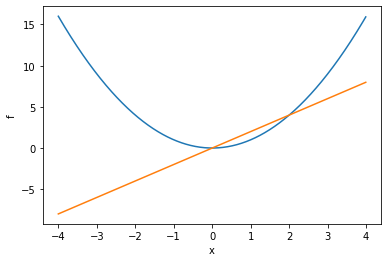

In [20]:
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 2, 1)
x = np.arange(-4, 4, 0.01)
f = square(x)
ax.plot(x, f)
f_prime = square_gradient(x)
ax.plot(x, f_prime)
ax.set_xlabel('x')
ax.set_ylabel('f')

<a id='non-linear-activation-functions'></a>
# Question 1
## Non-linear activation functions 
Fill in the functions that implement the non-linear functions which are used to produve the 
activations of the neurons of a neural network. Remember that for if $\sigma(x)$ is the 
sigmoid function, its derivative is $\sigma'(x)=\sigma(x)*(1-\sigma(x))$. Finally if 
$relu(x)=max(0,x)$ then $relu'(x>0)= 1$ and $relu'(x<=0)=0$.
#### Note: Do not change the functions and their arguments!

In [21]:
# TO DO (Q1)
# g(a) = 1 / (1 + exp(-a))
def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return g

# g'(a) = g(a) * (1 - g(a))
def sigmoid_gradient(z):
    g = sigmoid(z) * (1 - sigmoid(z))
    return g
# /TO DO (Q1)

# TO DO (Q1)
# g(a) = max(0, a)
def relu(x):
    # numpy.maximum can broadcast over array inputs.
    g = np.maximum(0, x)
    return g

def relu_gradient(z):
    
    relu_value = relu(z)
    # Assign the 1 or 0 to each value of the relu_value 
    g = np.where(relu_value > 0, 1, 0)
            
    return g
# /TO DO (Q1)

##### Visualize the functions and their gradients by plotting their output in the [-6,6] interval:

Text(0, 0.5, 'g')

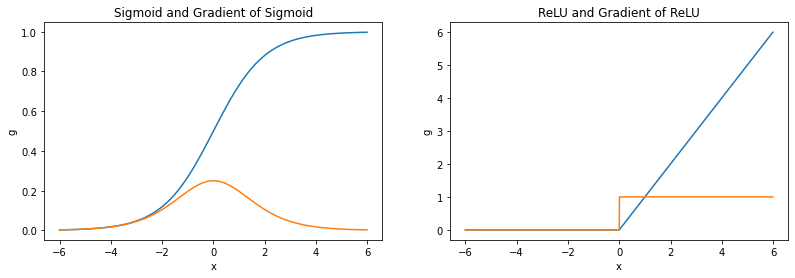

In [22]:
#TO DO (Q1)

# Plot the visualization of the sigmoid function
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 2, 1)
x = np.arange(-6, 6, 0.01)
g = sigmoid(x)
ax.plot(x, g)
g_derivative = sigmoid_gradient(x)
ax.plot(x, g_derivative)
ax.set_title("Sigmoid and Gradient of Sigmoid")
ax.set_xlabel('x')
ax.set_ylabel('g')

# Plot the visualization of the relu function
ax = fig.add_subplot(1, 2, 2)
x = np.arange(-6, 6, 0.01)
g = relu(x)
ax.plot(x, g)
g_derivative = relu_gradient(x)
ax.plot(x, g_derivative)
ax.set_title("ReLU and Gradient of ReLU")
ax.set_xlabel('x')
ax.set_ylabel('g')

# /TO DO (Q1)

# Question 2
<a id='the-neural-network'></a>
## The Neural Network Class 

In this assignement, in order to define, train and use a neural network you are first required to complete the implementation provided below. Every operation related to the network is defined as a method (e.g. `feedforward` , `backpropagation`, etc.) of the `NeuralNetwork` class. You only need to complete the code inside the `feedforward` and `loss_function` methods.

Go through the code to identify what each method inside the class does. Note that when first creating a `NeuralNetwork` class instance (for example as <a href='#Define-Network'> here</a>), the `__init__` method is executed and randomly initializes the network's weights, which then constitute an attribute of that instance. These weights are then modified by calling the `gradient_descent` method used to train the network. 


In [23]:
class NeuralNetwork(object):
    # For Question 2 first focus on __init__ and feedforward
    def __init__(self, nnodes, activation_functions='sigmoid'):
        # nnodes: number of hidden units per layer - e.g. [2,5,10] indicates a three-layer network with the respective number of nodes
        self.num_layers = len(nnodes)
        # weights, biases: list of the numpy arrays containing model parameters for linear layers
        # sampled originally from a gaussian distribution
        self.sizes = nnodes
        prng = RandomState(2)
        self.biases = [prng.randn(y, 1) for y in nnodes[1:]]
        self.weights = [prng.randn(y, x) for x, y in zip(nnodes[:-1], nnodes[1:])]
        # non-linearity, specified when the network is initialized
        self.activation_functions = activation_functions
        self.losses = [] # stores the losses during training
        self.accuracies = [] # stores the accuracies during training
        self.epoch_best = 0 # epoch during training when accuracy was max

    def feedforward(self, x):
        # Computes and returns the output of the network for a given input x
        # In our case x.shape = (2,1), i.e. the input is a 2-dimensional vector
        # It also returns intermediate linear and non-linear outputs of the layers
        # that can are for backpropagation when traning
        activations = [] # here we store the non-linear outputs of layers
        
        activations.append(x)
        zs = [] # here we store linear-outputs of layers

        # feedforward computation through all layers except the output layer
        for l in range(len(self.weights)-1):
            b = self.biases[l]
            w = self.weights[l]
            
            ##### TO DO Q2 linear output #####
            # The last line of the loop says that x = activation
            z = np.dot(w, x) + b
            ##### /TO DO Q2 linear output #####
            
            if self.activation_functions == 'sigmoid':
                
            ##### TO DO Q2 sigmoid #####
                activation = sigmoid(z)
            ##### /TO DO Q2 sigmoid #####
            
            elif self.activation_functions == 'relu':

            ##### TO DO Q2 relu #####
                activation = relu(z)
            ##### /TO DO Q2 relu #####

            # save z values for backprop (linear output of each layer)
            zs.append(z)
            # save activations for backprop (non-linear output of each layer)
            activations.append(activation)
            # the input at the next layer is the activation of the previous layer
            x = activation

        # feedforward computation through the output layer
        w = self.weights[-1]
        b = self.biases[-1]
        z = np.dot(w, x) + b # linear-output of output-layer
        
        ##### /TO DO Q2 softmax #####
        softmax_output = np.exp(z) / np.sum(np.exp(z))
        ##### /TO DO Q2 softmax #####

        activations.append(softmax_output)
        zs.append(z)
        return softmax_output, zs, activations
    
    def loss_function(self,X):
        # computes the cross entropy cost 
        # X is a list, each element of which is a tuple (x,y) 
        # where x is the input and y is the ground truth label
        # x has shape (2,1) and y is a scalar
        
        loss = 0 # initializing cost as 0
        for x, y in X: # looping elements of list X, each element is a pair x,y 
             # Note: y is a scalar with value either 0 or 1
            # Note: The cost formula requires a one-hot encoded version of y
            
            ##### /TO DO Q2 cost function #####
            
            # step 1 feedforward computation
            Softmax_Result, Linear_Output_Result, Non_Linear_Output_Result = self.feedforward(x)
            # step 2 cost value computation using x,y 
            
            # one hot encoding of the true class label y
            # if y=1 then the one-hot encoding of y is y =[0, 1]
            # if y=0 then the one-hot encoding of y is y =[1, 0]
            
            if y == 1:
                Encoded_Result = np.array([[0], [1]])
            else:
                Encoded_Result = np.array([[1], [0]])
                
            cost_value = -(np.sum(Encoded_Result * np.log(Softmax_Result)))
            
            # step 3 increment total_cost 
            loss = loss + cost_value
            
            ##### /TO DO Q2 cost function #####
            
        return loss 

    
    def gradient_descent(self, training_data, epochs, lr, test_data=None):
        # training_data is a list of tuples ([x1,x2],y) where y is the class and [x1,x2] is numpy array
        # lr is the learning_rate, it is scalar
        # epochs is a scalar value for the number of times the network 
        # is going to update its parameters after computing the gradient 
        # using all training examples
        
        n_train = len(training_data)
        accuracy_max = 0.0
        for j in range(epochs):
            # compute gradient using backprop and do gradient descent step to update params
            self.update_params(training_data, lr) 
            # compute loss value 
            loss = self.loss_function(training_data)
            # save loss value for visualization 
            self.losses.append(loss/n_train)
            if test_data:
                n_test = len(test_data)
                correct = self.evaluate(test_data)
                print ("Epoch {0}: Accuracy {1} / {2} loss: {3}".format(j, correct, n_test, loss/len(training_data)))
                accucary = correct / n_test
                self.accuracies.append(accucary)
                # if accuracy increased then store params 
                if accucary >= accuracy_max:
                    accuracy_max = accucary
                    w_best = self.weights
                    b_best = self.biases
                    epoch_best = j
                    # print('improved accuracy @ {}, {}'.format(j, accuracy_max))
            else:
                print ("No test_data given")
        if test_data:
            print('Model with highest accuracy {} achieved at epoch {}'.format(accuracy_max, epoch_best))
            # restore the weights and biases of the model with the highest accuracy
            self.weights = w_best 
            self.biases = b_best
            self.epoch_best = epoch_best
                
    def update_params(self, X, lr):
        # X is all the training data
        # X contains pairs (x,y) where x is the feature vector and y its class label
        N = len(X)
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        #Gradient Descent parameter updates
        for x, y in X:
            delta_grad_b, delta_grad_w = self.backprop(x, y) # take an example backpropagate to find the gradients
            grad_b = [nb+dnb for nb, dnb in zip(grad_b, delta_grad_b)] # accumulate gradients for biases
            grad_w = [nw+dnw for nw, dnw in zip(grad_w, delta_grad_w)] # accumulate gradients for weights
        
        # Update the weights and biases using the gradient of the cost computed using the whole training_dataset
        # divide by N to scale the overall gradient by the number of training examples
        self.weights = [w-lr*nw/N for w, nw in zip(self.weights, grad_w)]  
        self.biases = [b-lr*nb/N for b, nb in zip(self.biases,  grad_b)]
        
        
    def backprop(self, x, y):
        #Returns (grad_b, grad_w) representing the
        #gradients for the cost function  wrt b and w, initialized as zeros 
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]

        ######### Forward pass #########
        dummy, zs, activations= self.feedforward(x) 
        
        # one hot encoding of the true class label y
        # if y=1 then the one-hot encoding of y is y =[0, 1]
        # if y=0 then the one-hot encoding of y is y =[1, 0]
        if y == 0:
            y_one_hot = np.array([[1], [0]])
        else:
            y_one_hot = np.array([[0], [1]])
        
        ######## Backward pass ##########        
        # Grad at the ouput layer 
        
        dL_dz = activations[-1] - y_one_hot  # dL/dz (slide 51 derives this)
        # also this is the δ of slide 63 i.e the sensitivity of the loss to the activations of output layer
        
        # grad wrt the parameters (w,b) of the output layer     
        # for the grad of the loss wrt to the bias we have:
        # Given z = Wa + b  (we omit z(l) and a(l-1) for simplicity)
        # Chain_rule: dL_db = dL_dz * dz_db = dL_dz * 1 = dL_dz 
        grad_b[-1] = dL_dz  
        
        # for the grad of the loss wrt to the weight matrix with elements Wij we have:
        # dL_dWij = dL_dzi * dz[i]_dWij = dL_dz[i] * a[j]
        # which can be written as the following dot product 
        
        grad_w[-1] = np.dot(dL_dz, activations[-2].T)
        # Note: the resulting shape of grad_w[-1] is (2, num nodes of previous layer)
        # which is exactly the shape of the weight matrix mapping of the output layer 
        
        # By uncommenting the following lines the you can printing the shapes 
        # of each variable used to compute the gradient at the output layer
        '''
        print('---- shapes')
        print('output-layer')
        print('activation',activations[-1].shape) 
        print('z', zs[-1].shape)
        print('dL_dz',dL_dz.shape)
        print('grad_b:',grad_b[-1].shape,' grad_w:',grad_w[-1].shape)
        '''
        ############# TO DO Q2b explain what is done by following for loop###############
        
        # Grad at previous layers
        delta = dL_dz # delta of output layer
        L = self.num_layers # considering input layer + hidden layers + output layer
        # zs has L-1 elements , activations has L elements , self.weights of L-1 elements
        # start from 2nd-to-last layer (hence the L-2 index) and move backwards 
        for l in range(L-2, 0, -1): 
            # z is the linear output of the l-th layer
            z = zs[l-1] 
            
            # activation if the activation of the (l-1)-th layer
            activation=activations[l-1] 
            
            # weights that map the output of the 
            # l-th layer to the input of the (l+1)-th layer
            weights=self.weights[l] 
            
            # compute the value of the gradient of the non-linear function of the l-th layer 
            # evaluated at z: act_g = f'(z) 
            if self.activation_functions=='relu': act_g = relu_gradient(z)
            elif self.activation_functions=='sigmoid': act_g = sigmoid_gradient(z)
            
            # backpropagate delta from (l+1)-th layer to l-th layer
            prod  = np.dot(weights.T, delta)    
    
            delta = prod * act_g
            
            # gradients wrt to the parameters of the l-th layer
            grad_b[l-1] = delta 
            grad_w[l-1] = np.dot(delta, activation.T) 
            
            # By uncommenting the following lines the function 
            # will be printing the shapes of each variable             
            '''
            print('---- shapes')
            print('layer:',l)  
            print('activation ',activation.shape)
            print('z ', z.shape)
            print('w ',weights.shape)       
            print('prod ',prod.shape,'act_g',act_g.shape)
            print('delta ',delta.shape)
            print('grad_b ',grad_b[-l].shape,' grad_w ',grad_w[-l].shape) 
            '''
        return (grad_b, grad_w)
        ############# TO DO Q2b explain what is done by above for loop###############
        
    def evaluate(self, data):
        correct = 0
        for x, y in data:
            # we do not need to save activations and zs when classifying data 
            # we only care about the outupt 
            output, _, _ = self.feedforward(x)
            # predicted class is the index in the ouptut with maximal propability
            correct = correct + int(y == np.argmax(output))
        return correct


<a id='backprop'></a>
## Explanation of the backprop for loop



Answer:

On the basis of the comments in the backprop function, we can understand that the backprop for loop uses the gradient descent manner to compute the values of the gradient of the non-linear function (act_g), and further to use the (act_g) values to calculate the (delta) values to update the gradient of the biases, and use the (delta) values to multiply the activation values to update the gradient of the weights from the output layers to the input layers. The gradient descent manner can exhibit how much the parameter needs to change in positive or negative direction, further to minimize the value. Therefore, combining with the comments in the backprop for loop and my personal knowledge, I think that the backprop for loop in this section is mainly to adjust the weights and biases of the connections in the neural network repeatedly, therefore, we can obtain the update weights and biases results and return them to minimize the cost function in the neural network.

<a id='checking'></a>
## Gradient checking:
We are going to use $gradient$ $checking$ to check if the numerical (using approximations) 
and analytical (computed by our backprop implementation) gradient computations match. To 
test that we are going to check the gradients computed for a small neural network. 
Suppose we have a neural network with 2 dimensional inputs , 2 hidden layers of 4 neurons 
each with sigmoid non-linearities and an output layer of 2 neurons with sigmoid non-
linearity. This network is initialized as shown by the code in the next cell.

In [24]:
nnodes2 = [2, 4, 4, 2]
activation_functions2 = 'sigmoid' 
nnet_checking = NeuralNetwork(nnodes2, activation_functions2)

We are going to use a few training examples (m=50) to check if the analytical and numerical gradients match.

In [25]:
m = 50 # using 50 examples to do gradient checking 
train_data = data[1:m] 
checkNNGradients(nnet_checking, train_data)  # compute_numerical_gradient 

Relative difference 2.9835509789543276e-07 for layer 0 parameters
Analytical and numerical gradients match
as relative distance is less than 1e-5
Relative difference 5.933042961710719e-07 for layer 1 parameters
Analytical and numerical gradients match
as relative distance is less than 1e-5
Relative difference 5.040049399414082e-07 for layer 2 parameters
Analytical and numerical gradients match
as relative distance is less than 1e-5


# Question 3
<a id='Define-Network'></a>
## Define a Network 
To initialize a Neural Network we must provide two arguments: $nnodes$ and activation_functions. $nnodes$ is a list. Each element of $nnodes$ defines the number of neurons of each layer of the network. By convention the first element of $nnodes$ defines the dimensionality of the input layer of the network that is not associated with any weights and biases (i.e if the input to a network is $x \in R^{2}$ then the dimensionality of the input layer is $2$). The rest of the elements of $nnodes$ are used to initialize the weigths and biases of the hidden layers and the output layer. The activation_functions argument is a string that defines the type of non-linear function to be used for each neuron of the hidden layer. Our implementation supports relu and sigmoid as non-linear activation functions. 

In [26]:
nnodes = [2, 10, 10, 2]
activation_functions = 'sigmoid' # this can either be 'sigmoid' or 'relu'
nnet = NeuralNetwork(nnodes, activation_functions) # creating a NeuralNetwork instance
# accessing the weights attribute of the nnet instance we can print weight shapes per layer
print(['layer {}: w {}'.format(layer, w.shape) for w, layer in zip(nnet.weights, range(len(nnet.weights)))]) 

['layer 0: w (10, 2)', 'layer 1: w (10, 10)', 'layer 2: w (2, 10)']


## Train a network with sigmoid activation functions.
Note that for each training epoch we compute the mean cost and accuracy on the training set. 
Once the training is completed visualize the cost / accuracy curves and the estimated posterior using the provided code. It is recomended that you keep the learning rate and number of epochs as provided below.

In [27]:
learning_rate = 2
epochs = 5000  # usually has converged for that many epochs
train_data = data
test_data = data 
nnet.gradient_descent(train_data, epochs, learning_rate, test_data)

Epoch 0: Accuracy 150 / 300 loss: 3.483158241515567
Epoch 1: Accuracy 150 / 300 loss: 2.6606844419640385
Epoch 2: Accuracy 150 / 300 loss: 2.5494340874402064
Epoch 3: Accuracy 150 / 300 loss: 1.3534527867117754
Epoch 4: Accuracy 150 / 300 loss: 1.4363862269113086
Epoch 5: Accuracy 150 / 300 loss: 0.9673692133965774
Epoch 6: Accuracy 150 / 300 loss: 0.8973147567921474
Epoch 7: Accuracy 150 / 300 loss: 0.7885149621945051
Epoch 8: Accuracy 150 / 300 loss: 0.7509202174490244
Epoch 9: Accuracy 150 / 300 loss: 0.7198429324132001
Epoch 10: Accuracy 150 / 300 loss: 0.7060588088768246
Epoch 11: Accuracy 150 / 300 loss: 0.6964837340050933
Epoch 12: Accuracy 150 / 300 loss: 0.6914407013048818
Epoch 13: Accuracy 150 / 300 loss: 0.6880043338615661
Epoch 14: Accuracy 167 / 300 loss: 0.685860165057049
Epoch 15: Accuracy 150 / 300 loss: 0.6842678693015404
Epoch 16: Accuracy 203 / 300 loss: 0.6830657892275953
Epoch 17: Accuracy 152 / 300 loss: 0.6820438567852721
Epoch 18: Accuracy 195 / 300 loss: 0.681

best_accuracy: 0.8533333333333334 achieved at epoch: 3395


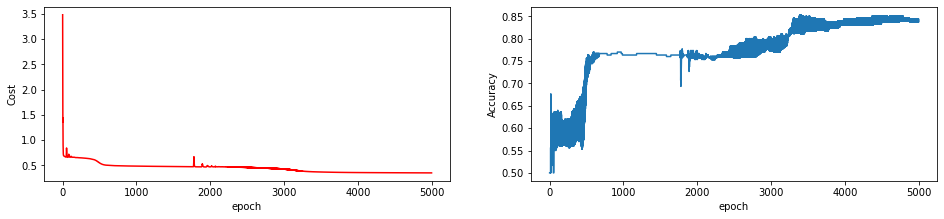

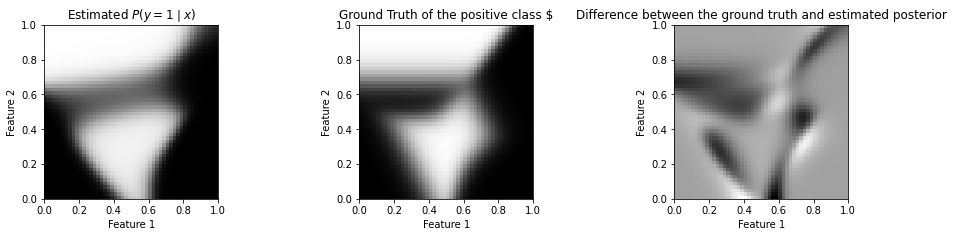

In [28]:
# We get the cost and accuracy during training 
# by referencing the nnet object's attributes costs and accuracies which we give to the visualization function
losses_training = nnet.losses
accuracy_training = nnet.accuracies
visualize_cost_accuracy_curves(accuracy_training, losses_training)
# we give the nnet object to the second visualization function to visualize the estimated posterior
visualize_posterior(nnet)

<a id='Train2'></a>
## Train a network with ReLU activation functions.
Define a new network with the same number of nodes and name it nnet_2 in order to avoid erasing the previous model. Once the training is completed visualize the cost / accuracy curves and the estimated posterior using the provided code. 

In [29]:
nnodes = [2, 10, 10, 2]
learning_rate = 0.2
epochs = 5000
############ TO DO Q2d ############################
activation_functions = 'relu' # this can either be 'sigmoid' or 'relu'
nnet_2 = NeuralNetwork(nnodes, activation_functions) # creating a NeuralNetwork instance
# accessing the weights attribute of the nnet_2 instance we can print weight shapes per layer
print(['layer {}: w {}'.format(layer, w.shape) for w, layer in zip(nnet_2.weights, range(len(nnet_2.weights)))])

train_data = data
test_data = data
nnet_2.gradient_descent(train_data, epochs, learning_rate, test_data)
########### TO DO Q2d ###########################

['layer 0: w (10, 2)', 'layer 1: w (10, 10)', 'layer 2: w (2, 10)']
Epoch 0: Accuracy 150 / 300 loss: 3.9904283688354862
Epoch 1: Accuracy 167 / 300 loss: 0.8386755655947119
Epoch 2: Accuracy 167 / 300 loss: 0.7916380197596271
Epoch 3: Accuracy 166 / 300 loss: 0.7566042796220939
Epoch 4: Accuracy 174 / 300 loss: 0.7316889658682839
Epoch 5: Accuracy 162 / 300 loss: 0.7124499355662152
Epoch 6: Accuracy 176 / 300 loss: 0.6971245120505175
Epoch 7: Accuracy 165 / 300 loss: 0.6846449716351413
Epoch 8: Accuracy 169 / 300 loss: 0.674095478784333
Epoch 9: Accuracy 170 / 300 loss: 0.6650088975393321
Epoch 10: Accuracy 167 / 300 loss: 0.6570642437309453
Epoch 11: Accuracy 180 / 300 loss: 0.6502626510047742
Epoch 12: Accuracy 183 / 300 loss: 0.6442447055448116
Epoch 13: Accuracy 185 / 300 loss: 0.6387913997876699
Epoch 14: Accuracy 188 / 300 loss: 0.6341020694643269
Epoch 15: Accuracy 192 / 300 loss: 0.629896464730675
Epoch 16: Accuracy 193 / 300 loss: 0.6260620495165959
Epoch 17: Accuracy 202 / 3

best_accuracy: 0.8466666666666667 achieved at epoch: 3182


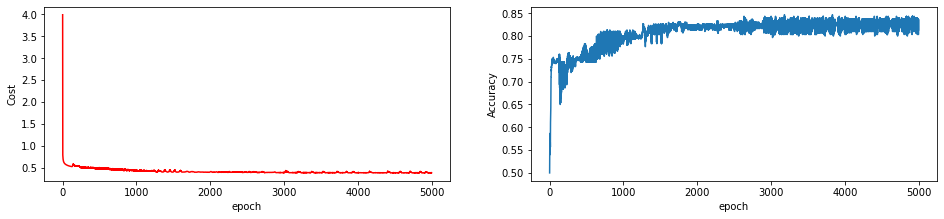

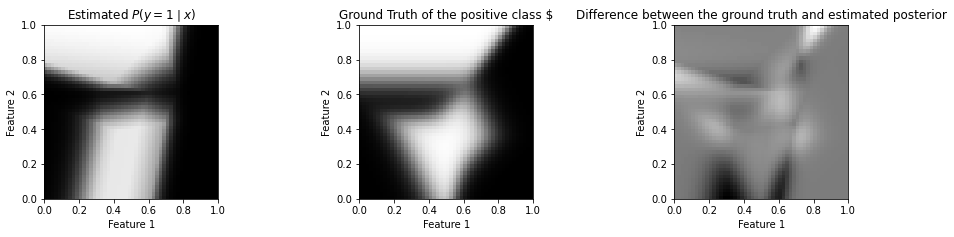

In [30]:
losses_training = nnet_2.losses
accuracy_training = nnet_2.accuracies
visualize_cost_accuracy_curves(accuracy_training, losses_training)
visualize_posterior(nnet_2)

<a id='Compare'></a>
## Compare the two networks below:

Answer:

According to the above results, we can understand that the ReLU activation functions possess better performance. Some reasons illustrating my perspectives will be shed light on as follows. In the first place, on the basis of the Question 1 formulas and plot results, we can understand that the Sigmoid activation functions are not the zero centered activation function. In addition, the values after the Sigmoid activation functions will be in range 0 to 1 (input values between -infinity to +infinity). Compared with the Sigmoid activation functions, the ReLU activation functions will convert all negative input values to 0, as a result, it doesn't need to consider any negative values problems. Besides, due to the values after the ReLU activation functions will be in range 0 to +infinity, hence, there is no issue of vanishing gradient problems (maximum threshold values are +infinity), therefore, the output prediction accuracy and efficiency are maximum. 

Furthermore, in the light of the above training network results, we can notice that even though the Sigmoid activation functions network possess highest accuracy compared with the ReLU activation functions network finally, however, its accuracy-epoch is not stable. In the accuracy-epoch results, we can find that the Sigmoid activation functions network result moves up and down drastically, and it looks like it hasn't reached the convergence (still bumpy). In contrast, during the 5000 epochs, the ReLU activation functions network can converge quickly, and its cost-epoch and accuracy-epoch plots are stable (have little bumpy). In addition, through the difference between the ground truth and estimated posterior results, we can find that the difference in the Sigmoid activation functions network is larger. To conclude, we can know that the ReLU activation functions network performs better compared with the Sigmoid activation functions network.  
